In [ ]:
import json
from pathlib import Path
import openai
import re
import math
import numpy as np
import torch
from transformers import pipeline
import time
from typing import Optional

from utils import extract_numbers,find_first_empty_index,process_scientific_notation,extract_numeric_answer
openai.api_key  = "OPENAI_API_KEY"

from sentence_transformers import SentenceTransformer

model_sentence = SentenceTransformer("all-MiniLM-L6-v2")

In [ ]:
# Download APBench_Gamma.json from woodywu/APBench 
filename = 'APBench_Gamma.json'
data = json.loads(Path(filename).read_text())
# Print the tenth problem and the 1st question among the questions
index, order = 10, 1
content   = data[index]['Content']
question_solution_so_on = data[index]['Questions'][order]
print("Question:", question_solution_so_on['Question'])
print("Solution:", question_solution_so_on['Solution'])
print("Answer:", question_solution_so_on['Answer'])
print("Format:", question_solution_so_on['Format'])
print("Source:", question_solution_so_on['Source'])

In [3]:
def get_embedding(text):
    return model_sentence.encode(text)

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [ ]:
import anthropic
# Create an instance of the Anthropics API client
client = anthropic.Anthropic(api_key='XAI_API_KEY')  

# Systematic Running on Selected Questions

In [6]:
def evaluate_frac(frac,
                  content_str,
                  question_str,
                  solution_str,
                  all_correct_QAs,
                  client,
                  get_embedding,
                  cosine_similarity):
    """
    Build the prompt using the first `frac` fraction of `solution_str`,
    call the model, compute the remaining solution, then return the cosine
    similarity between the model's reply and the remainder.
    """
    # how many chars to include
    n = int(len(solution_str) * frac)

    # Build the prompt
    msg = (
        f"{all_correct_QAs} {content_str} {question_str} "
        "Without any extra words, please specify the answer in the final sentence with this form: "
        "'the answer is (answer)'. The answer should either be numeric or symbolic (not words)."
    )
    # append the fraction of the solution
    msg = f"{msg}, {solution_str[:n]}"

    # call the model
    response = client.messages.create(
        model="claude-3-7-sonnet-20250219",
        max_tokens=1000,
        temperature=0,
        messages=[{"role":"user","content":[{"type":"text","text":msg}]}]
    )
    reply = response.content[0].text.strip()

    # compute remaining solution (after the prefix you gave it)
    remain_sol = solution_str[n:]

    # compute similarity
    sim = cosine_similarity(
        get_embedding(solution_str[:n]+reply),
        get_embedding(solution_str[:n]+remain_sol)
    )

    return sim, reply, remain_sol

def extract_user_answer(reply: str) -> Optional[str]:
    """
    Extracts the substring following 'the answer is' (case-sensitive or not)
    from a model’s reply. Returns the answer (including any LaTeX) or None.
    """
    pattern = r'the answer is\s*(.*)|The answer is\s*(.*)'
    match = re.search(pattern, reply)
    if not match:
        return None
    # whichever group captured the text
    answer = match.group(1) or match.group(2)
    return answer.strip()


In [7]:
def evaluate_and_update(
    reply: str,
    format_str: str,
    answer_str: str,
    question_str: str,
    content_str: str,
    solution_str: str,
    user_answer_str: str,
    q_idx: int,
    match_results_local: list,
    correct_QAs: list,
    get_embedding,
    cosine_similarity,
    extract_numeric_answer,
    extract_numbers,
    process_scientific_notation,
    openai_client
):
    """
    Evaluate a single model reply and update match_results_local[q_idx] (0 or 1)
    and append to correct_QAs if matched.

    Returns the match_result (0 or 1).
    """
    match_result = 0

    if format_str == 'message':
        # 1) embedding score
        score_embedding = cosine_similarity(
            get_embedding(reply),
            get_embedding(answer_str)
        )
        print(f"[message] embedding similarity: {score_embedding:.3f}")

        # 2) GPT-based score
        gpt_prompt = f"""
Compare the following reply with the expected answer and evaluate their alignment using these criteria:

1. Relevance: Does the reply address the scientific goals and concepts?
2. Completeness: Does it cover the key points?
3. Accuracy: Is the reasoning correct?

Question: {question_str}
Expected Answer: {answer_str}
Reply: {reply}

After evaluating, provide a similarity score between 0 and 10, where:  
    - 10 means the reply perfectly aligns with the expected answer.  
    - 0 means the reply does not align at all.  

Only return the numeric score.
"""
        response = openai_client.chat.completions.create(
            model="gpt-4",
            messages=[{"role": "user", "content": gpt_prompt}],
            temperature=0
        )
        raw = response.choices[0].message.content.strip()
        try:
            score_gpt = float(raw) / 10.0
        except ValueError:
            score_gpt = 0.0
        print(f"[message] GPT score: {score_gpt:.3f}")

        # combine
        score = 0.5 * score_embedding + 0.5 * score_gpt
        print(f"[message] combined score: {score:.3f}")

        if score > 0.6:
            match_results_local[q_idx] = 1
            extra = (
                f"For reference, Q: '{content_str}{question_str}' "
                f"has answer: {reply}"
            )
            correct_QAs.append(extra)
        else:
            match_results_local[q_idx] = 0 

    elif format_str == 'numeric':
        # attempt to parse a numeric from user_answer_str
        print("[numeric] parsing numeric answer")
        power = []
        try:
            if user_answer_str is None:
                user_answer_str = ''
                raise TypeError("user_answer_str cannot be None")
            user_answer_num_str = extract_numeric_answer(user_answer_str)
            user_answer_num = extract_numbers(user_answer_num_str)[0]
        except:
            # check if answer string has power expression
            user_answer_str, power = process_scientific_notation(user_answer_str)
            user_answer_num = None

        # when openai is able to handle the operation
        if not power:
            user_answer_num = user_answer_num
            answer_str_num = extract_numbers(answer_str)[0]
            match_results_local[q_idx] = 0
        # other cases
        else:
            try:
                if power:
                    print("pow")
                    user_answer_pow = extract_numbers(user_answer_str.strip())[2]
                    user_answer_num = extract_numbers(user_answer_str.strip())[0] * 10**user_answer_pow
                    power = extract_numbers(answer_str)[1]
                    answer_str_num = extract_numbers(answer_str)[0] * 10**power

                    print("user_answer_num", user_answer_num)
                    print("answer_str_num", answer_str_num)

                else:
                    print("no pow")
                    print(user_answer_str.strip())
                    user_answer_num = extract_numbers(user_answer_str.strip())[0]
                    answer_str_num = extract_numbers(answer_str)[0]

                    print("user_answer_num", user_answer_num)
                    print("answer_str_num", answer_str_num)

            except:
                user_answer_num = None
                answer_str_num = None
                match_results_local[q_idx] = 0

        if user_answer_num is not None and user_answer_num != 0:
            
            margin = 0.1 + 0.01 * math.log(abs(answer_str_num))
            print("margin: ", margin)
            if answer_str_num == user_answer_num:
                match_results_local[q_idx] = 1
                extra_str = "For reference, a previous question: " + question_str + ". It has answer " + str(user_answer_num)
                correct_QAs.append(extra_str)
                print("Exact Match")
            elif abs(answer_str_num - user_answer_num) / abs(user_answer_num) < abs(margin):
                match_results_local[q_idx] = 1
                extra_str = "For reference, a previous question: " + question_str + ". It has answer " + str(user_answer_num)
                correct_QAs.append(extra_str)
                print("Rough Match")
            else:
                match_results_local[q_idx] = 0
                print("No Match")

    else:
        raise ValueError(f"Unknown format_str: {format_str!r}")

    # update the result list and return
    match_result = match_results_local[q_idx]
    return match_result

## Looping Over idx, q_idx of interest

In [20]:
pairs = [(6, 2), (14, 0), (19, 6), (22, 2), (22, 3), (24,1), \
    (6,4), (23, 0), (26, 2), (27, 0), (32, 0)]

results_summary_multi, results_summary = [], []
# add a time evaluation
start_time = time.time()
# add a loop of multiple rounds of the evaluation
for round in range(5):
    for idx, q_idx in pairs:
        print(f"\n=== Running idx={idx}, q_idx={q_idx} ===")

        # Extract data
        content_str = data[idx]['Content']
        questions_solutions = data[idx]['Questions']
        question_entry = questions_solutions[q_idx]
        question_str = question_entry['Question']
        solution_str = question_entry['Solution']
        answer_str = question_entry['Answer']
        format_str = question_entry['Format']
        match_results_local = [[] for _ in questions_solutions]
        correct_QAs = []
        all_correct_QAs = " "

        results = []
        for frac in np.arange(0.1, 1.0, 0.1):
            sim, reply, remain_sol = evaluate_frac(
                frac,
                content_str,
                question_str,
                solution_str,
                all_correct_QAs,
                client,
                get_embedding,
                cosine_similarity
            )

            user_answer_str = extract_user_answer(reply)

            result = evaluate_and_update(
                reply=reply,
                format_str=format_str,
                answer_str=answer_str,
                question_str=question_str,
                content_str=content_str,
                solution_str=solution_str,
                user_answer_str=user_answer_str,
                q_idx=q_idx,
                match_results_local=match_results_local,
                correct_QAs=correct_QAs,
                get_embedding=get_embedding,
                cosine_similarity=cosine_similarity,
                extract_numeric_answer=extract_numeric_answer,
                extract_numbers=extract_numbers,
                process_scientific_notation=process_scientific_notation,
                openai_client=openai
            )

            results.append((frac, sim, result))

        # Convert to numpy arrays
        fracs = np.array([float(f) for f, _, _ in results])
        sims = np.array([float(s) for _, s, _ in results])
        binary_results = np.array([float(r) for _, _, r in results])

        FLI = np.log(sims + 1e-10)  # avoid log(0)
        coef = np.polyfit(fracs, FLI, 1)
        slope = coef[0]
        mean_result = binary_results.mean()

        # Store in summary
        results_summary.append({
            "idx": idx,
            "q_idx": q_idx,
            "FLI": FLI.tolist(),
            "Binary_Results": binary_results.tolist(),
            "slope": slope,
            "mean_result": mean_result
        })
    # add end time
    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.2f} seconds")
    # show result summary
    for item in results_summary:
        print(f"\n(idx={item['idx']}, q_idx={item['q_idx']})")
        print(f"FLI: {item['FLI']}")
        print(f"Binary_Results: {item['Binary_Results']}")
        print(f"Slope: {item['slope']:.3f}")
        print(f"Mean result: {item['mean_result']:.3f}")
    
    # Store results_summary in multiple rounds
    results_summary_multi.append({
        "round": round,
        "results_summary": results_summary
    })


=== Running idx=6, q_idx=2 ===
[numeric] parsing numeric answer
margin:  0.229348909777664
No Match
[numeric] parsing numeric answer
margin:  0.229348909777664
No Match
[numeric] parsing numeric answer
margin:  0.229348909777664
No Match
[numeric] parsing numeric answer
margin:  0.229348909777664
No Match
[numeric] parsing numeric answer
margin:  0.229348909777664
No Match
[numeric] parsing numeric answer
margin:  0.229348909777664
No Match
[numeric] parsing numeric answer
margin:  0.229348909777664
No Match
[numeric] parsing numeric answer
margin:  0.229348909777664
No Match
[numeric] parsing numeric answer

=== Running idx=14, q_idx=0 ===
[numeric] parsing numeric answer
margin:  0.15409858741280946
Rough Match
[numeric] parsing numeric answer
margin:  0.15409858741280946
Rough Match
[numeric] parsing numeric answer
margin:  0.15409858741280946
Rough Match
[numeric] parsing numeric answer
margin:  0.15409858741280946
No Match
[numeric] parsing numeric answer
margin:  0.1540985874128

In [ ]:
# dump my results_summary into a pickle file
import pickle
with open('results_summary.pkl', 'wb') as f:
    pickle.dump(results_summary_multi, f)

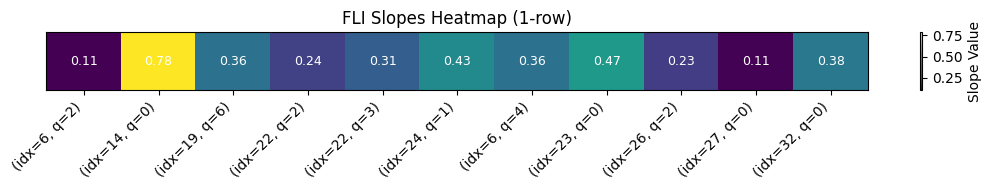

In [26]:
# single heatmap
import matplotlib.pyplot as plt

# Extract slopes and labels
slopes = [float(entry['slope']) for entry in results_summary]
labels = [f"(idx={entry['idx']}, q={entry['q_idx']})" for entry in results_summary]

# Reshape into 1-row heatmap
slope_array = np.array(slopes).reshape(1, -1)

# Plot
plt.figure(figsize=(len(slopes), 2))
plt.imshow(slope_array, cmap="viridis", aspect="auto")

# Annotate values on heatmap
for i, val in enumerate(slopes):
    plt.text(i, 0, f"{val:.2f}", ha='center', va='center', color='white', fontsize=9)

# Axis setup
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45, ha='right')
plt.yticks([])
plt.title("FLI Slopes Heatmap (1-row)")
plt.colorbar(label="Slope Value")
plt.tight_layout()
plt.show()
